# Dependence on Classical Optimizers

Classical optimizers are one of the main components of variational algorithms. While the expectation values, or costs, are calculated using the outcomes of quantum circuits, the optimization over the cost function landscape is performed using classical optimizers. So, the performance of the classical optimizer plays an important role in the performance of the variational algorithms.

In this notebook, we will study the effect of classical optimizers on the variational algorithms. More specifically, we will investigate how the optimizers affect the convergence of the algorithms when all other parameters are identical. We will compare against a few optimizers available in the `scipy.optimize` package, in particular, we will compare the algorithms across the following four optimizers:

1. __COBYLA__

    Constrained Optimization BY Liner Approximation, or COBYLA, is a derivative-free optimization technique to minimize functions with one or more parameters. So, these methods are well-suited to minimize a cost function whose derivatives are unknown or are extremely hard to compute. However, COBYLA assumes that the initial point is in the neighborhood of the optimal point (trust region). So, when the neighborhood of the optimal point is known, this method can be very effective.

2. __L-BGFS-B__

    BFGS is a quasi-Newton optimization method due to Broyden, Fletcher, Goldfarb, and Shanno. L-BFGS-B is a version of the limited-memory BFGS (L-BFGS) that solves the optimization problem subject to bounds on the parameters. This is a gradient-based optimization technique, but it still builds upon the knowledge of the trust region.

3. __Nelder-Mead__

    Nelder-Mead is a gradient-free optimization technique used to optimize unconstrained optimization problems. The Nelder-Mead method starts with a simplex and moves this simplex towards the optimal region of the search space. Similar to COBYLA, this technique is very useful when the derivatives of the function is unknown or is extremely hard to compute.

4. __Differential Evolution__

    Differential Evolution is an evolutionary algorithm to find the minimum of the cost function. While COBYLA, L-BFGS-B and Nelder-Mead are local optimizers, differential evolution is a global optimizer. It is a stochastic gradient-based method that starts with a set of candidate solutions and combines them over iterations to obtain the optimal solution to the optimization problem.

To perform the comparison between the classical optimizers, we use 10 randomly generated graph instances. These instances are solved using different variational algorithms with the setting that the maximum number of layers is 3. For each of the algorithm-optimizer pairs, we compute the absolute error defined as $$error = |true\_optimal - exp\_optimal|.$$

### Importing Required Functions

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from qiskit import *
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp

import rustworkx as rx
import numpy as np
from rustworkx.visualization import mpl_draw
import matplotlib.pyplot as plt

from src.graph_gen import *
from src.hamiltonian_gen import get_hamiltonian_from_graph
from src.helper_functions import top_k_counts

In [3]:
from src.bfminimize import BFMinimizeCombinatorial
from src.qaoa import QAOA
from src.adaptqaoa import AdaptQAOA
from src.vqe import VQE
from src.dcqaoa import DCQAOA

In [4]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

First, we will create 10 different graph instances and calculate the true optimal cost values of the cost_hamiltonian corresponding to each of the graph instances. The optimal values are computed using the brute-force approach. These optimal values are then used to compute the error for each algorithm-optimizer pair.

In [5]:
num_instances = 10
graph_instances = []
graph_hamiltonians = []

for i in range(num_instances):
    graph = generate_random_graph(6, 0.4)
    graph_instances.append(graph)
    cost_hamiltonian = get_hamiltonian_from_graph(graph)
    graph_hamiltonians.append(cost_hamiltonian)

In [6]:
brute_optimal_cost = []
for hamiltonian in graph_hamiltonians:
    brute = BFMinimizeCombinatorial(hamiltonian)
    brute.run()
    brute_optimal_cost.append(brute.optimal_value)

avg_brute_optimal_cost = sum(brute_optimal_cost)/num_instances

In [7]:
# Setting the max-repetitions to 3 and the optimizer list.

max_reps = 3
optimizer_list = ['differential_evolution', 'COBYLA', 'L-BFGS-B', 'Nelder-Mead',]

### VQE

Due to limitation on the time, we will limit the optimizers for VQE to 'COBYLA', 'L-BFGS', and 'Nelder-Mead' for comparison. This is because of the fact the even ansatz with less number of layers tend to have large number of parameters. For instance, in our case of $3$ layers, the number of parameters in the ansatz is $18$. The convergence time of differential evolution optimizer for large number of parameters, like $18$, is slightly prohibitive on a local system. So, we ignore the performance of the differential evolution optimizer for VQE in this notebook.

In [8]:
vqe_optimal_cost = []

for optimizer in optimizer_list[1:]:
    print(f"Solving for Optimizer {optimizer}...")
    vqe_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        vqe_ansatz = TwoLocal(
            hamiltonian.num_qubits,
            rotation_blocks = ['rx'],
            entanglement_blocks = ['cz'],
            entanglement = 'full',
            reps = 3
        )
        vqe = VQE(hamiltonian, ansatz = vqe_ansatz, optimizer = optimizer)
        vqe.run()
        vqe_optimal_cost[-1].append(vqe.optimal_value)

Solving for Optimizer COBYLA...
Solving for Optimizer L-BFGS-B...
Solving for Optimizer Nelder-Mead...


In [9]:
avg_vqe_optimal_cost = []
for optimal_cost_arr in vqe_optimal_cost:
    avg_vqe_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_vqe_error = [np.abs(avg_brute_optimal_cost - v_opt) for v_opt in avg_vqe_optimal_cost]

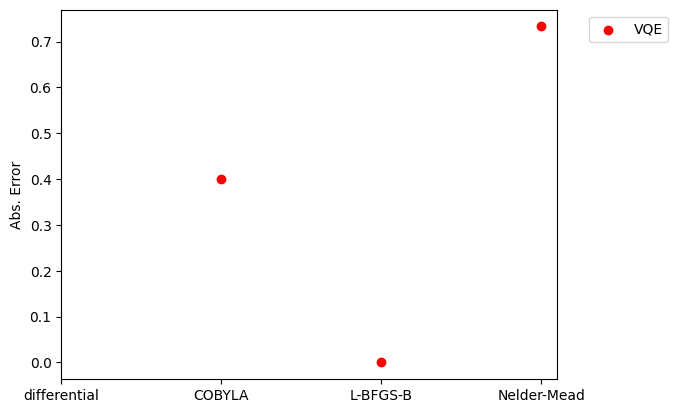

In [26]:
plt.scatter(range(1,4), avg_vqe_error, color = 'r', label='VQE')
plt.xticks([0, 1, 2, 3], ['differential', 'COBYLA', 'L-BFGS-B', 'Nelder-Mead'])
plt.ylabel("Abs. Error")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### QAOA

In [11]:
qaoa_optimal_cost = []

for optimizer in optimizer_list:
    print(f"Solving for Optimizer {optimizer}...")
    qaoa_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        qaoa = QAOA(hamiltonian, optimizer = optimizer)
        qaoa.run()
        qaoa_optimal_cost[-1].append(qaoa.optimal_value)

Solving for Optimizer differential_evolution...
Solving for Optimizer COBYLA...
Solving for Optimizer L-BFGS-B...
Solving for Optimizer Nelder-Mead...


In [12]:
avg_qaoa_optimal_cost = []
for optimal_cost_arr in qaoa_optimal_cost:
    avg_qaoa_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_qaoa_error = [np.abs(avg_brute_optimal_cost - v_opt) for v_opt in avg_qaoa_optimal_cost]

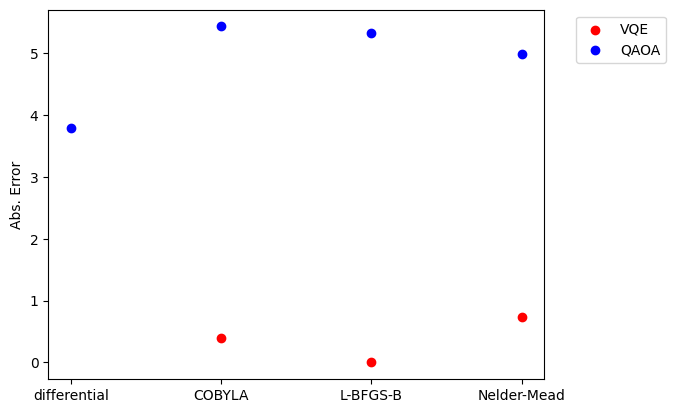

In [27]:
plt.scatter(range(1,4), avg_vqe_error, color = 'r', label='VQE')
plt.scatter(range(4), avg_qaoa_error, color = 'b', label='QAOA')
plt.xticks([0, 1, 2, 3], ['differential', 'COBYLA', 'L-BFGS-B', 'Nelder-Mead'])
plt.ylabel("Abs. Error")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### ADAPT-QAOA

In [14]:
aqaoa_single_optimal_cost = []

for optimizer in optimizer_list:
    print(f"Solving for Optimizer {optimizer}...")
    aqaoa_single_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        aqaoa_single = AdaptQAOA(hamiltonian, mixer_pool_type='single', optimizer = optimizer)
        aqaoa_single.run()
        aqaoa_single_optimal_cost[-1].append(aqaoa_single.optimal_value)

Solving for Optimizer differential_evolution...
Solving for Optimizer COBYLA...
Solving for Optimizer L-BFGS-B...
Solving for Optimizer Nelder-Mead...


In [15]:
avg_aqaoa_single_optimal_cost = []
for optimal_cost_arr in aqaoa_single_optimal_cost:
    avg_aqaoa_single_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_aqaoa_single_error = [np.abs(avg_brute_optimal_cost - aq_opt) for aq_opt in avg_aqaoa_single_optimal_cost]

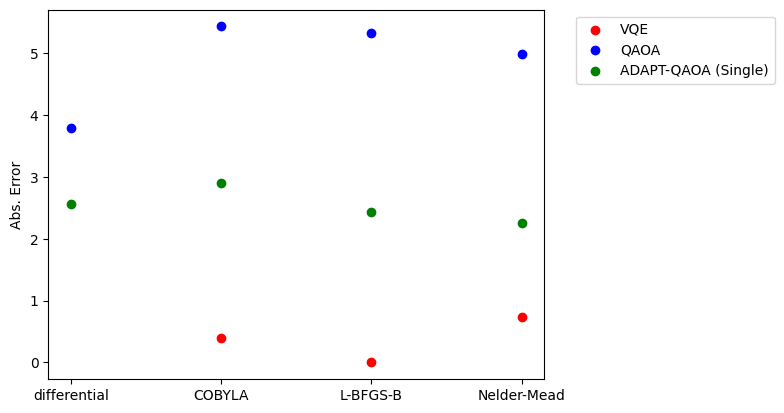

In [28]:
plt.scatter(range(1,4), avg_vqe_error, color = 'r', label='VQE')
plt.scatter(range(4), avg_qaoa_error, color = 'b', label='QAOA')
plt.scatter(range(4), avg_aqaoa_single_error, color='g', label='ADAPT-QAOA (Single)')

plt.xticks([0, 1, 2, 3], ['differential', 'COBYLA', 'L-BFGS-B', 'Nelder-Mead'])
plt.ylabel("Abs. Error")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [17]:
aqaoa_double_optimal_cost = []

for optimizer in optimizer_list:
    print(f"Solving for Optimizer {optimizer}...")
    aqaoa_double_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        aqaoa_double = AdaptQAOA(hamiltonian, mixer_pool_type='double', optimizer = optimizer)
        aqaoa_double.run()
        aqaoa_double_optimal_cost[-1].append(aqaoa_double.optimal_value)

Solving for Optimizer differential_evolution...
Solving for Optimizer COBYLA...
Solving for Optimizer L-BFGS-B...
Solving for Optimizer Nelder-Mead...


In [18]:
avg_aqaoa_double_optimal_cost = []
for optimal_cost_arr in aqaoa_double_optimal_cost:
    avg_aqaoa_double_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_aqaoa_double_error = [np.abs(avg_brute_optimal_cost - aq_opt) for aq_opt in avg_aqaoa_double_optimal_cost]

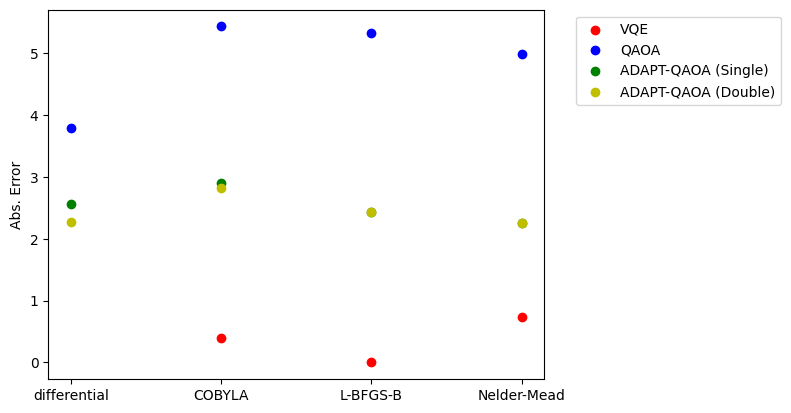

In [29]:
plt.scatter(range(1,4), avg_vqe_error, color = 'r', label='VQE')
plt.scatter(range(4), avg_qaoa_error, color = 'b', label='QAOA')
plt.scatter(range(4), avg_aqaoa_single_error, color='g', label='ADAPT-QAOA (Single)')
plt.scatter(range(4), avg_aqaoa_double_error, color='y', label='ADAPT-QAOA (Double)')

plt.xticks([0, 1, 2, 3], ['differential', 'COBYLA', 'L-BFGS-B', 'Nelder-Mead'])
plt.ylabel("Abs. Error")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### DC-QAOA

In [21]:
dcqaoa_optimal_cost = []

for optimizer in optimizer_list:
    print(f"Solving for Optimizer {optimizer}...")
    dcqaoa_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        dcqaoa = DCQAOA(hamiltonian, cd_hamiltonian_type = ['XY', 'YX', 'YZ', 'ZY'], optimizer = optimizer)
        dcqaoa.run()
        dcqaoa_optimal_cost[-1].append(dcqaoa.optimal_value)

Solving for Optimizer differential_evolution...
Solving for Optimizer COBYLA...
Solving for Optimizer L-BFGS-B...
Solving for Optimizer Nelder-Mead...


In [22]:
avg_dcqaoa_optimal_cost = []
for optimal_cost_arr in dcqaoa_optimal_cost:
    avg_dcqaoa_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_dcqaoa_error = [np.abs(avg_brute_optimal_cost - aq_opt) for aq_opt in avg_dcqaoa_optimal_cost]

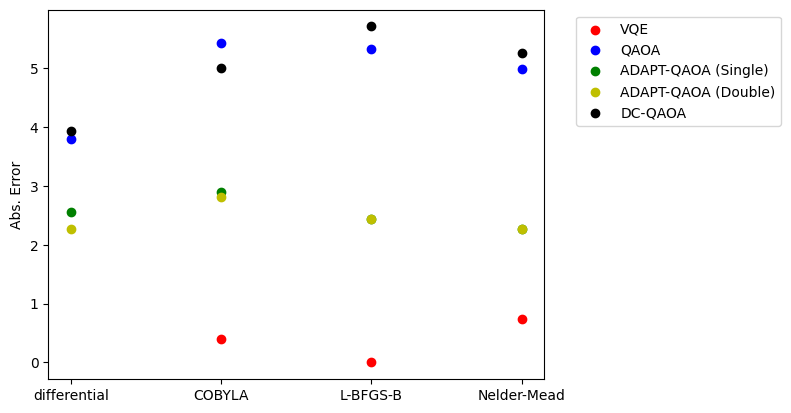

In [25]:
plt.scatter(range(1,4), avg_vqe_error, color = 'r', label='VQE')
plt.scatter(range(4), avg_qaoa_error, color = 'b', label='QAOA')
plt.scatter(range(4), avg_aqaoa_single_error, color='g', label='ADAPT-QAOA (Single)')
plt.scatter(range(4), avg_aqaoa_double_error, color='y', label='ADAPT-QAOA (Double)')
plt.scatter(range(4), avg_dcqaoa_error, color='k', label='DC-QAOA')
plt.xticks([0, 1, 2, 3], ['differential', 'COBYLA', 'L-BFGS-B', 'Nelder-Mead'])
plt.ylabel("Abs. Error")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We notice that the differential evolution optimizer performs the best for all the algorithms. This is not so surprising since the other three optimizers are local optimizers, whereas the differential evolution optimizer is a global optimizer. However, this likable performance comes at a cost. Due to the globally-optimizing nature of the differential evolution optimizer, this optimizer uses significantly more number of calls to the cost function, which takes significantly more time when compared to the other optimizers.

Of the local optimizers, their performances are very similar to each other, and there is no clear winner. This could possibly indicate that the cost function landscape is relatively smooth with very few gradient spikes. However, it is to be noted that for this demonstration, we are working on a low-dimensional space since the number of parameters is comparatively small. We cannot rule out that for problems of practical interest, which often have a large number of nodes in the graph, we end up with a complex, high-dimensional landscape.